## **Requirements**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 76 bytes


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 43.6 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: Shapely
    Found existing installation: Shapely 1.8.4
    Uninstalling Shapely-1.8.4:
      Successfully uninstalled Sha

### **Cuda Ext**

## **Utils:**

In [ ]:
from typing import NamedTuple, Optional

import numpy as np
import torch
from shapely.geometry import Polygon
from skimage.draw import line, polygon_perimeter

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Star(NamedTuple):
    points: np.ndarray
    label: np.array


class StarImage(NamedTuple):
    image: np.ndarray
    label: np.ndarray


def _rotate(points: np.ndarray, theta: float) -> np.ndarray:
    return points @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def _cornerarr(arr):
    points = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]]).astype(np.float)
    points *= np.array([arr[3], arr[4]]) / 2
    points = _rotate(points, arr[2])
    points += np.array([arr[0], arr[1]])
    return points

def _corners(pos_x: float, pos_y: float, yaw: float, width: float, height: float) -> np.ndarray:
    points = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]]).astype(np.float)
    points *= np.array([width, height]) / 2
    points = _rotate(points, yaw)
    points += np.array([pos_x, pos_y])
    return points


def _star(
    pos: np.asarray,
    yaw: float,
    side_len: float,
    i_stretch: float,
    j_stretch: float,
    roundness: float,
) -> Star:
    """
    Returns:
        Star:
            the polygon points of the star and corresponding label
    """

    # normal star (centered at origin, side length 1) with given roundness
    points = np.array(
        [
            [1, 0],
            [roundness, roundness],
            [0, 1],
            [-roundness, roundness],
            [-1, 0],
            [-roundness, -roundness],
            [0, -1],
            [roundness, -roundness],
        ]
    )

    # stretch, rotate, translate
    width_height = (side_len) * np.array([i_stretch, j_stretch])
    points *= width_height / 2
    points = _rotate(points, yaw)
    points += pos

    return Star(points, np.asarray([*pos, yaw, *(width_height)]))


def _clipped_normal(mean, var, clip_low, clip_high, size=1) -> np.ndarray:
    return np.clip(np.random.normal(mean, var, size=size), clip_low, clip_high)


def _pos(s: float) -> np.ndarray:
    return np.random.randint(40, s - 40, size=2)


def _yaw() -> float:
    return np.random.uniform(0, 2 * np.pi)


def _side_len() -> int:
    return np.random.randint(70, 90)


def _width_stretch() -> float:
    return np.clip(np.random.normal(0.7, 0.4 / 3), 0.6, 0.8)


def _height_stretch() -> float:
    return np.clip(np.random.normal(1.3, 0.4 / 3), 1.10, 1.3)


def _roundness() -> float:
    return np.clip(np.random.normal(0.25, 0.2 / 3), 0.10, 0.40)

def synthesize_data(
    has_star: bool = None,
    noise_level: float = 0.2,
    n_lines: int = 8,
    image_size: int = 200,
) -> StarImage:
    """
    Args:
        has_star (bool, optional):
            Whether a star is included. Defaults to None, in which case it is
            True with frequency 0.8.
        noise_level (float, optional):
            Amount of noise. Defaults to 0.2.
        n_lines (int, optional): Number of extra lines. Defaults to 12.
        image_size (int, optional): Size of synthesized image. Defaults to 200.

    Returns:
        StarImage:
            Synthesized image and corresponding label. As described in the
            README, the label consists of the bounding box's x coordinate,
            y coordinate, yaw, width, and height; when there is no star,
            it is an array of np.nan's.
    """
    if has_star is None:
        has_star = np.random.choice([True, False], p=(0.8, 0.2))

    image = _clipped_normal(0.0, noise_level, 0, 1, size=(image_size, image_size))

    def noisy_draw(x, y):
        valid = (x >= 0) & (x < image_size) & (y >= 0) & (y < image_size)
        image[x[valid], y[valid]] = _clipped_normal(0.25, noise_level, 0, 1, size=np.sum(valid))

    # star (or no-star)
    if has_star:
        points, label = _star(
            _pos(image_size), _yaw(), _side_len(), _width_stretch(), _height_stretch(), _roundness()
        )
        noisy_draw(*polygon_perimeter(points[:, 0], points[:, 1]))
    else:
        label = np.full(5, np.nan)

    # lines
    for _ in range(n_lines):
        noisy_draw(
            *line(*np.random.randint(-image_size // 2, image_size + image_size // 2, size=4))
        )

    return StarImage(image.T, label)  # coordinate transform


def score_iou(pred: np.ndarray, label: np.ndarray) -> Optional[float]:
    assert (
        pred.size == 5 and label.size == 5
    ), "Preds & labels should have length 5. Use nan's for no-star."

    pred_no_star = np.any(np.isnan(pred))
    label_no_star = np.any(np.isnan(label))

    if not label_no_star and not pred_no_star:
        # true positive
        t = Polygon(_corners(*label))
        p = Polygon(_corners(*pred))
        iou = t.intersection(p).area / t.union(p).area
        return iou
    elif (label_no_star and not pred_no_star) or (not label_no_star and pred_no_star):
        # false positive or false negative
        return 0
    elif label_no_star and pred_no_star:
        # true negative
        return None
    else:
        raise NotImplementedError

In [ ]:
def _batch(batch_size, has_star=True):
    image, label = zip(*[synthesize_data(has_star=has_star) for _ in range(batch_size)])
    # Stack into array
    image = np.stack(image)
    label = np.stack(label)
    # Change the yaw from [0,2*pi) to [0,pi) since the bounding box will still be identical
    label = change_yaw(label)
    # Convert from numpy to torch
    image = torch.from_numpy(np.asarray(image, dtype=np.float32))
    label = torch.from_numpy(np.asarray(label, dtype=np.float32))
    image = torch.unsqueeze(image, 1)
    return image, label

def _calcIOU(pred, label):
    t = Polygon(_corners(*label))
    p = Polygon(_corners(*pred))
    iou = t.intersection(p).area / t.union(p).area
    return iou

def _calcIOUarr(pred, label):
    t = Polygon(_cornerarr(label))
    p = Polygon(_cornerarr(pred))
    iou = t.intersection(p).area / t.union(p).area
    return iou

def _boxLength(pred, label):
    t = _corners(*label)
    p = _corners(*pred)
    x_t = t[:,0]
    y_t = t[:,1]
    x_p = p[:,0]
    y_p = p[:,1]
    x = np.concatenate((x_t, x_p))
    y = np.concatenate((y_p, y_t))
    top = min(y)
    bottom = max(y)
    left = min(x)
    right = max(x)
    width = abs(right - left)
    height = abs(bottom - top)
    return height**2 + width**2

def _normalize(label, img_size=200):
    normalized_center = label[0:2] / img_size
    if label[2] >= np.pi:
        label[2] = label[2] - np.pi
    normalized_yaw = [label[2] / np.pi]
    normalized_size = label[3:] / img_size
    normalized = np.concatenate((normalized_center, normalized_yaw, normalized_size))
    return normalized

def _unnormalize(label, img_size=200):
    center = label[0:2] * img_size
    yaw = [label[2] * np.pi]
    size = label[3:] * img_size
    original = np.concatenate((center, yaw, size))
    return original

def _unnormalizeTensor(label, img_size=200):
    center = label[:, 0:2] * img_size
    yaw = label[:, 2] * np.pi
    yaw = yaw.reshape((yaw.shape[0], 1))
    size = label[:,3:] * img_size
    original = np.concatenate((center, yaw, size), axis=1)
    return original

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for 

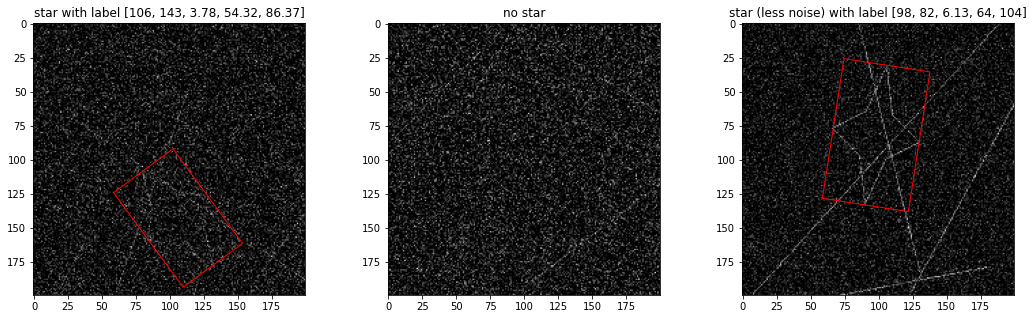

In [ ]:
import matplotlib.pyplot as plt

def plot(ax, image, label, text):
    ax.imshow(image, cmap="gray")
    ax.set_title(text)
    if label.size > 0:
        bbox = _corners(*label)
        ax.fill(bbox[:, 0], bbox[:, 1], facecolor="none", edgecolor="r")


def prettify_np(a):
    return list(map(lambda x: int(x) if x.is_integer() else round(x, 2), a.tolist()))


if __name__ == "__main__":
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    image, label = synthesize_data(has_star=True)
    plot(ax[0], image, label, f"star with label {prettify_np(label)}")

    image, label = synthesize_data(has_star=False)
    plot(ax[1], image, label, "no star")

    image, label = synthesize_data(has_star=True, noise_level=0.1)
    plot(ax[2], image, label, f"star (less noise) with label {prettify_np(label)}")

    fig.savefig("example.png")


## **Calculate Loss**

In [ ]:
import math
import torch
import numpy as np

def ciou_loss_batch(pred, gt, reduction='none'):
    losses = []
    ious = []
    for i in range(len(gt)):
        loss, iou = ciou_loss(pred[i], gt[i])
        losses.append(loss)
        ious.append(iou)
    losses = np.array(losses)
    ious = np.array(ious)
    if reduction == "mean":
        losses = losses.mean()
        ious = ious.mean()
    return losses, ious

def diou_loss_batch(pred, gt, reduction='none', yaw=False):
    losses = []
    ious = []
    for i in range(len(gt)):
        loss, iou = diou_loss(pred[i], gt[i], yaw)
        losses.append(loss)
        ious.append(iou)
    losses = np.array(losses)
    ious = np.array(ious)
    if reduction == "mean":
        losses = losses.mean()
        ious = ious.mean()
    return losses, ious

def ciou_loss(
    boxes1,
    boxes2,
    eps: float = 1e-7,
):
    dloss, iou = diou_loss(boxes1, boxes2)

    v = (4 / (math.pi ** 2)) * (boxes2[2] - boxes1[2])**2
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    loss = dloss + alpha * v
    return loss, iou

def diou_loss(
    boxes1,
    boxes2,
    yaw: bool = False,
    eps: float = 1e-7,
):
    iou = _calcIOUarr(boxes1, boxes2)
    c2 = _boxLength(boxes1, boxes2) + eps
    d2 = ((boxes1[0] - boxes2[0])**2) + ((boxes1[1]-boxes2[1])**2)
    loss = 1 - iou + (d2 / c2)
    if yaw:
        loss += abs(boxes1[2] - boxes2[2]) / boxes2[2]
    return loss, iou


def diou_loss_original(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "none",
    eps: float = 1e-7,
) -> torch.Tensor:
    """
    Distance Intersection over Union Loss (Zhaohui Zheng et. al)
    https://arxiv.org/abs/1911.08287
    Args:
        boxes1, boxes2 (Tensor): box locations in XYXY format, shape (N, 4) or (4,).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
        eps (float): small number to prevent division by zero
    """

    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    # TODO: use torch._assert_async() when pytorch 1.8 support is dropped
    assert (x2 >= x1).all(), "bad box: x1 larger than x2"
    assert (y2 >= y1).all(), "bad box: y1 larger than y2"

    # Intersection keypoints
    xkis1 = torch.max(x1, x1g)
    ykis1 = torch.max(y1, y1g)
    xkis2 = torch.min(x2, x2g)
    ykis2 = torch.min(y2, y2g)

    intsct = torch.zeros_like(x1)
    mask = (ykis2 > ykis1) & (xkis2 > xkis1)
    intsct[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
    union = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsct + eps
    iou = intsct / union

    # smallest enclosing box
    xc1 = torch.min(x1, x1g)
    yc1 = torch.min(y1, y1g)
    xc2 = torch.max(x2, x2g)
    yc2 = torch.max(y2, y2g)
    diag_len = ((xc2 - xc1) ** 2) + ((yc2 - yc1) ** 2) + eps

    # centers of boxes
    x_p = (x2 + x1) / 2
    y_p = (y2 + y1) / 2
    x_g = (x1g + x2g) / 2
    y_g = (y1g + y2g) / 2
    distance = ((x_p - x_g) ** 2) + ((y_p - y_g) ** 2)

    # Eqn. (7)
    loss = 1 - iou + (distance / diag_len)
    if reduction == "mean":
        loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
    elif reduction == "sum":
        loss = loss.sum()

    return loss, iou


def ciou_loss_original(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "none",
    eps: float = 1e-7,
) -> torch.Tensor:
    """
    Complete Intersection over Union Loss (Zhaohui Zheng et. al)
    https://arxiv.org/abs/1911.08287
    Args:
        boxes1, boxes2 (Tensor): box locations in XYXY format, shape (N, 4) or (4,).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
        eps (float): small number to prevent division by zero
    """

    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    # TODO: use torch._assert_async() when pytorch 1.8 support is dropped
    assert (x2 >= x1).all(), "bad box: x1 larger than x2"
    assert (y2 >= y1).all(), "bad box: y1 larger than y2"

    # Intersection keypoints
    xkis1 = torch.max(x1, x1g)
    ykis1 = torch.max(y1, y1g)
    xkis2 = torch.min(x2, x2g)
    ykis2 = torch.min(y2, y2g)

    intsct = torch.zeros_like(x1)
    mask = (ykis2 > ykis1) & (xkis2 > xkis1)
    intsct[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
    union = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsct + eps
    iou = intsct / union

    # smallest enclosing box
    xc1 = torch.min(x1, x1g)
    yc1 = torch.min(y1, y1g)
    xc2 = torch.max(x2, x2g)
    yc2 = torch.max(y2, y2g)
    diag_len = ((xc2 - xc1) ** 2) + ((yc2 - yc1) ** 2) + eps

    # centers of boxes
    x_p = (x2 + x1) / 2
    y_p = (y2 + y1) / 2
    x_g = (x1g + x2g) / 2
    y_g = (y1g + y2g) / 2
    distance = ((x_p - x_g) ** 2) + ((y_p - y_g) ** 2)

    # width and height of boxes
    w_pred = x2 - x1
    h_pred = y2 - y1
    w_gt = x2g - x1g
    h_gt = y2g - y1g
    v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(w_gt / h_gt) - torch.atan(w_pred / h_pred)), 2)
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    # Eqn. (10)
    loss = 1 - iou + (distance / diag_len) + alpha * v
    if reduction == "mean":
        loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

## **Model Training**

In [ ]:

import torch
torch.cuda.empty_cache()

In [ ]:
import typing as t

from sklearn.utils import shuffle
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

class _Net(nn.Module):
    def __init__(self):
        super(_Net, self).__init__()
        self.pool = nn.Sequential(nn.Conv2d(1, 32, 3, padding=(1, 1)), nn.BatchNorm2d(32), nn.ReLU())
        self.conv0 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=(1, 1)), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2))

        self.conv1 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=(1, 1)), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=(1, 1)), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2))

        self.conv3 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=(1, 1)), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv4 = nn.Sequential(nn.Conv2d(512, 512, 3, padding=(1, 1)), nn.BatchNorm2d(512), nn.ReLU())

        self.conv5 = nn.Sequential(nn.Conv2d(512, 16, 3, padding=(1, 1)), nn.BatchNorm2d(16), nn.ReLU())

    def forward(self, x):
        x = self.pool(x)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = torch.flatten(x,1)
        return x

class Localizer(nn.Module):
    def __init__(self):
        super(Localizer, self).__init__()
        self.fc1 = nn.Linear(16*12*12, 128)
        self.fc2 = nn.Linear(128,5)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(16*12*12, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
        return x

class StarModel(nn.Module):
    def __init__(self):
        super(StarModel, self).__init__()
        self.network = _Net()
        self.localizer = Localizer()
        self.classifier = Classifier()
        self.head = 'localizer'

    def forward(self, x):
        x = self.network(x)
        if self.head == 'localizer':
            return self.localizer(x)
        else:
            return self.classifier(x)


class StarDataset(torch.utils.data.Dataset):
    """Return star image and labels"""

    def __init__(self, data_size=50000, has_star=True):
        self.data_size = data_size
        self.has_star = has_star

    def __len__(self) -> int:
        return self.data_size

    def __getitem__(self, idx) -> t.Tuple[torch.Tensor, torch.Tensor]:
        image, label = synthesize_data(has_star=self.has_star)
        label = _normalize(label)
        return image[None], label


def train(model: StarModel, dl: StarDataset, num_epochs: int, optimizer, loss_fn, scheduler, localizer=True) -> StarModel:
    #Initiate model for training (Batchnorm and dropout)
    model.train()
    # Get model summary
    summary(model, (1,200,200))
    # Initialize total loss and iou

    for epochs in range(num_epochs):
        print(f"EPOCH: {epochs}")
        epoch_losses = []
        epoch_ious = []
        for image, label in tqdm(dl, total=len(dl)):
            image = image.to(DEVICE).float()
            label = label.to(DEVICE).float()
            optimizer.zero_grad()
            preds = model(image)
            if localizer:
                loss, iou = loss_fn(
                    _unnormalize(preds.cpu().detach().numpy()),
                    _unnormalize(label.cpu().detach().numpy())
                )
                epoch_ious.append(iou)
                epoch_losses.append(loss)
            else:
                loss = loss_fn(preds, label)
                loss.backward()
                epoch_losses.append(loss.cpu().detach().numpy())
            optimizer.step()
        scheduler.step()
        print(epochs)
        print(np.mean(epoch_losses))
        if localizer:
            print(np.mean(epoch_ious))

    return model


def main():
    # Initialize model and set to available device
    model = StarModel().to(DEVICE)
    # Initialize loss functions and optimizer for localization
    optimizer = torch.optim.Adam(model.parameters())
    loss_localizer = diou_loss_batch
    epochs = 10
    batch_size = 64
    scheduler = MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
    # Train the localizer
    star_model = train(
        model,
        torch.utils.data.DataLoader(StarDataset(data_size=128000), batch_size=batch_size, shuffle=True),
        num_epochs=epochs,
        optimizer=optimizer,
        loss_fn=loss_localizer, 
        scheduler=scheduler
    )

    print("Classification Training")
    torch.save(star_model.state_dict(), "model.pickle")


if __name__ == "__main__":
    main()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             320
       BatchNorm2d-2         [-1, 32, 200, 200]              64
              ReLU-3         [-1, 32, 200, 200]               0
            Conv2d-4         [-1, 64, 200, 200]          18,496
       BatchNorm2d-5         [-1, 64, 200, 200]             128
              ReLU-6         [-1, 64, 200, 200]               0
         MaxPool2d-7         [-1, 64, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]          73,856
       BatchNorm2d-9        [-1, 128, 100, 100]             256
             ReLU-10        [-1, 128, 100, 100]               0
        MaxPool2d-11          [-1, 128, 50, 50]               0
           Conv2d-12          [-1, 256, 50, 50]         295,168
      BatchNorm2d-13          [-1, 256, 50, 50]             512
             ReLU-14          [-1, 256,

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 2000/2000 [12:21<00:00,  2.70it/s]


0
0.8037075474824867
0.24837759116579172
EPOCH: 1


100%|██████████| 2000/2000 [12:21<00:00,  2.70it/s]


1
0.8042440429590155
0.24794424554214298
EPOCH: 2


100%|██████████| 2000/2000 [12:11<00:00,  2.74it/s]


2
0.8039929205163141
0.24817274762215594
EPOCH: 3


100%|██████████| 2000/2000 [12:05<00:00,  2.76it/s]


3
0.8036971601383792
0.24842384721125768
EPOCH: 4


100%|██████████| 2000/2000 [12:03<00:00,  2.76it/s]


4
0.8031954495493825
0.2488324715663928
EPOCH: 5


100%|██████████| 2000/2000 [12:06<00:00,  2.75it/s]


5
0.8048035883344922
0.24755480458032636
EPOCH: 6


100%|██████████| 2000/2000 [12:05<00:00,  2.76it/s]


6
0.8037426260795447
0.24839559851965254
EPOCH: 7


100%|██████████| 2000/2000 [12:05<00:00,  2.76it/s]


7
0.8042157623923452
0.24803961992957033
EPOCH: 8


100%|██████████| 2000/2000 [12:06<00:00,  2.75it/s]


8
0.804438361991191
0.24784792661252222
EPOCH: 9


100%|██████████| 2000/2000 [12:03<00:00,  2.77it/s]

9
0.8046872357219498
0.2475883218474932
Classification Training


## **Score**

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

def load_model():
    model = StarModel()
    model.to(DEVICE)
    with open("model.pickle", "rb") as f:
        state_dict = torch.load(f, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def eval(*, n_examples: int = 1024) -> None:
    model = load_model()
    scores = []
    for _ in tqdm(range(n_examples)):
        image, label = synthesize_data()
        with torch.no_grad():
            pred = model(torch.Tensor(image[None, None]).to(DEVICE))
        np_pred = pred[0].detach().cpu().numpy()
        scores.append(score_iou(np_pred, label))

    ious = np.asarray(scores, dtype="float")
    ious = ious[~np.isnan(ious)]  # remove true negatives
    print((ious > 0.7).mean())


if __name__ == "__main__":
    eval()

  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 1024/1024 [00:06<00:00, 154.61it/s]

0.0
